In [1]:
%matplotlib inline
import os
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_corr_matrix_w_maps
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
from utils import RESULTS_ROOT

ORDERED_FOLDERS = [
    "20210916_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211018_FTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211019_AAFTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EC_subjectwise",
    "20211119_FTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4microstates_2.0-20.0Hz_EC_seeded_subjectwise",
    "20210917_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_FTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_AAFTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211121_AAFTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211121_IAAFTsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4PCA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20210917_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_FTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_AAFTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_IAAFTsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    # "20211020_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4ICA_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211025_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_FTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_AAFTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_IAAFTsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    # "20211025_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EC_subjectwise",
    "20211120_FTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_AAFTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_IAAFTsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
    "20211120_SHUFFLEsurrs_4hmm_2.0-20.0Hz_EC_seeded_subjectwise",
]

fold_names = [
    "-".join(fold.split("_")[1:3]).replace("-2.0-20.0Hz", "")
    for fold in ORDERED_FOLDERS
]

RESULTS_FOLDER = os.path.join(RESULTS_ROOT, "aggregated")

In [2]:
def plot_matrix_w_annot(array, annot=True, mask_pvals=False, title=""):
    plt.figure(figsize=(12, 10))
    if annot and array.ndim == 3:
        annot = np.tril(array[..., 0], k=-1)
        annot += np.triu(array[..., 1], k=1)
        annot[np.eye(annot.shape[0], dtype=bool)] = np.nan
        mask = np.isnan(annot)
    else:
        mask = np.zeros_like(annot[..., 0], dtype=bool)
    plot_array = array if array.ndim == 2 else array[..., 0]
    if mask_pvals:
        mask = np.logical_or(array[..., 1] > 0.05, mask)
    sns.heatmap(
        plot_array,
        square=True,
        annot=annot,
        mask=mask,
        fmt=".2f",
        annot_kws={"size": 9},
    )
    for line in np.arange(5, array.shape[0], 5):
        plt.axhline(line, color="w")
        plt.axvline(line, color="w")
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()
    plt.plot(
        [xlims[0], xlims[1]],
        [ylims[1], ylims[0]],
        "--",
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    _ = plt.yticks(
        ticks=np.arange(20) + 0.5,
        labels=["data", "FT", "AAFT", "IAAFT", "shuffle"] * 4,
        rotation=0,
    )
    _ = plt.xticks(
        ticks=np.arange(20) + 0.5,
        labels=["data", "FT", "AAFT", "IAAFT", "shuffle"] * 4,
        rotation=90,
    )
    for pos, method in enumerate(["microstates", "PCA", "ICA", "HMM"]):
        plt.text(
            -4, 2.5 + 5 * pos, method, size=20, ha="left", rotation=90, va="center"
        )
        plt.text(2.5 + 5 * pos, 24, method, size=20, ha="center")
    plt.title(title)

## Compare latent segmentation

1. concat all subjects' segmentations per method and per data (data vs. surrogates)
2. segmentations are ordinal, i.e. use Kendall's $\tau$ or Spearman

In [3]:
# subjects intersection
all_sets = []
for fold in ORDERED_FOLDERS:
    files = sorted(glob(f"{os.path.join(RESULTS_ROOT, fold)}/sub*.npz"))
    all_sets.append(set([file.split("/")[-1].split("_")[0] for file in files]))
subjects_intersection = set.intersection(*all_sets)

In [4]:
all_segmentations = []
all_segmentations_subjectwise = []
for fold in ORDERED_FOLDERS:
    concat_segmentations = []
    for file in sorted(glob(f"{os.path.join(RESULTS_ROOT, fold)}/sub*.npz")):
        subj = file.split("/")[-1].split("_")[0]
        if subj not in subjects_intersection:
            continue
        loaded = np.load(file)
        concat_segmentations.append(loaded["latent_segmentation"])
    all_segmentations_subjectwise.append(concat_segmentations)
    concat = np.concatenate(concat_segmentations)
    all_segmentations.append(concat)

all_segmentations = np.vstack(all_segmentations)
taus = np.zeros((len(ORDERED_FOLDERS), len(ORDERED_FOLDERS), 2))
spearman = np.zeros_like(taus)
chi2 = np.zeros_like(taus)
taus_subjectwise = np.zeros(
    (len(subjects_intersection), len(ORDERED_FOLDERS), len(ORDERED_FOLDERS), 2)
)
spearman_subjectwise = np.zeros_like(taus_subjectwise)
chi2_subjectwise = np.zeros_like(taus_subjectwise)

In [5]:
with tqdm(total=len(ORDERED_FOLDERS) ** 2) as pbar:
    for i in tqdm(range(len(ORDERED_FOLDERS))):
        for j in range(len(ORDERED_FOLDERS)):
            tau = pg.corr(
                all_segmentations[i, :], all_segmentations[j, :], method="kendall"
            )
            sp = pg.corr(
                all_segmentations[i, :], all_segmentations[j, :], method="spearman"
            )
            chi2_test = pg.chi2_independence(
                data=pd.DataFrame(
                    {"x": all_segmentations[i, :], "y": all_segmentations[j, :]}
                ),
                x="x",
                y="y",
            )[2]
            taus[i, j, 0] = tau["r"]
            taus[i, j, 1] = tau["p-val"]
            spearman[i, j, 0] = sp["r"]
            spearman[i, j, 1] = sp["p-val"]
            chi2[i, j, 0] = chi2_test.loc[0, "chi2"]
            chi2[i, j, 1] = chi2_test.loc[0, "pval"]
            for subj in range(len(subjects_intersection)):
                tau = pg.corr(
                    all_segmentations_subjectwise[i][subj],
                    all_segmentations_subjectwise[j][subj],
                    method="kendall",
                )
                sp = pg.corr(
                    all_segmentations_subjectwise[i][subj],
                    all_segmentations_subjectwise[j][subj],
                    method="spearman",
                )
                chi2_test = pg.chi2_independence(
                    data=pd.DataFrame(
                        {
                            "x": all_segmentations_subjectwise[i][subj],
                            "y": all_segmentations_subjectwise[j][subj],
                        }
                    ),
                    x="x",
                    y="y",
                )[2]
                taus_subjectwise[subj, i, j, 0] = tau["r"]
                taus_subjectwise[subj, i, j, 1] = tau["p-val"]
                spearman_subjectwise[subj, i, j, 0] = sp["r"]
                spearman_subjectwise[subj, i, j, 1] = sp["p-val"]
                chi2_subjectwise[subj, i, j, 0] = chi2_test.loc[0, "chi2"]
                chi2_subjectwise[subj, i, j, 1] = chi2_test.loc[0, "pval"]
            pbar.update(1)

  0%|                                                                                                                                                                                | 0/20 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1

In [6]:
xr.Dataset(
    {
        "kendall": (
            ["subject", "decomp_type1", "decomp_type2", "value"],
            taus_subjectwise,
        ),
        "spearman": (
            ["subject", "decomp_type1", "decomp_type2", "value"],
            spearman_subjectwise,
        ),
        "chi2": (
            ["subject", "decomp_type1", "decomp_type2", "value"],
            chi2_subjectwise,
        ),
    },
    coords={
        "subject": list(subjects_intersection),
        "decomp_type1": fold_names,
        "decomp_type2": fold_names,
        "value": ["measure", "p-value"],
    },
).to_netcdf(os.path.join(RESULTS_FOLDER, "segmentation_subjectwise_EC_seeded.nc"))

xr.Dataset(
    {
        "kendall": (["decomp_type1", "decomp_type2", "value"], taus),
        "spearman": (["decomp_type1", "decomp_type2", "value"], spearman),
        "chi2": (["decomp_type1", "decomp_type2", "value"], chi2),
    },
    coords={
        "decomp_type1": fold_names,
        "decomp_type2": fold_names,
        "value": ["measure", "p-value"],
    },
).to_netcdf(os.path.join(RESULTS_FOLDER, "segmentation_EC_seeded.nc"))

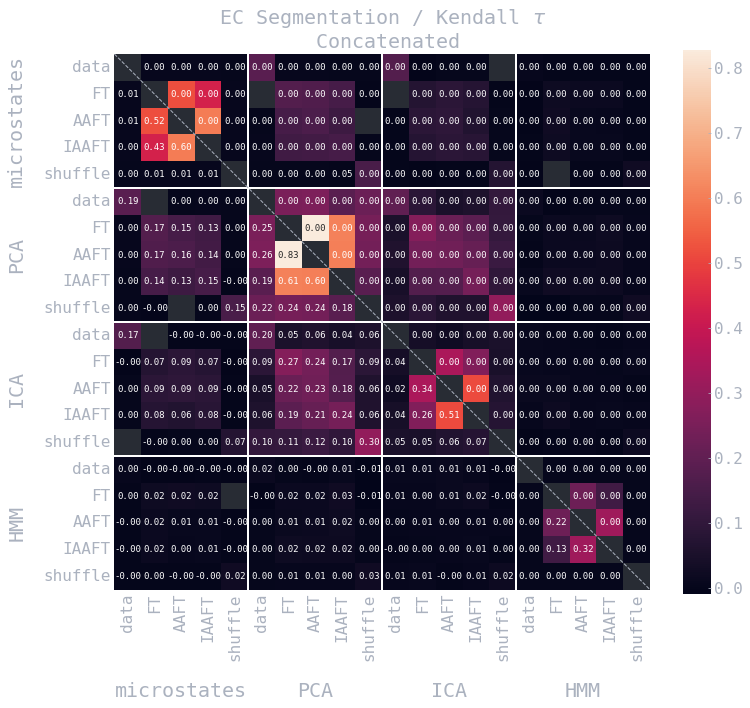

In [7]:
plot_matrix_w_annot(
    taus,
    annot=True,
    mask_pvals=True,
    title=r"EC Segmentation / Kendall $\tau$" + "\n Concatenated",
)

## Compare latent maps

### Group maps
1. simple correlation between states A -- D

### Subject maps
1. correlation between states A -- D, per subject between methods
2. plot mean / std of correlations per subject
3. maybe plot distribution of correlations per subject

In [8]:
group_maps = []
for fold in ORDERED_FOLDERS:
    loaded = np.load(os.path.join(RESULTS_ROOT, fold, "group_mean.npz"))
    group_maps.append(loaded["latent_maps"])

In [9]:
group_corrs = np.zeros((4, len(ORDERED_FOLDERS), len(ORDERED_FOLDERS), 2))
for i in range(len(ORDERED_FOLDERS)):
    for j in range(len(ORDERED_FOLDERS)):
        for ms in range(4):
            group_corrs[ms, i, j, :] = np.abs(
                spearmanr(group_maps[i][ms, :], group_maps[j][ms, :])
            )

In [10]:
xr.DataArray(
    group_corrs,
    dims=["state", "decomp_type1", "decomp_type2", "value"],
    coords={
        "state": ["A", "B", "C", "D"],
        "decomp_type1": fold_names,
        "decomp_type2": fold_names,
        "value": ["measure", "p-value"],
    },
).to_netcdf(os.path.join(RESULTS_FOLDER, "group_topomaps_EC_seeded.nc"))

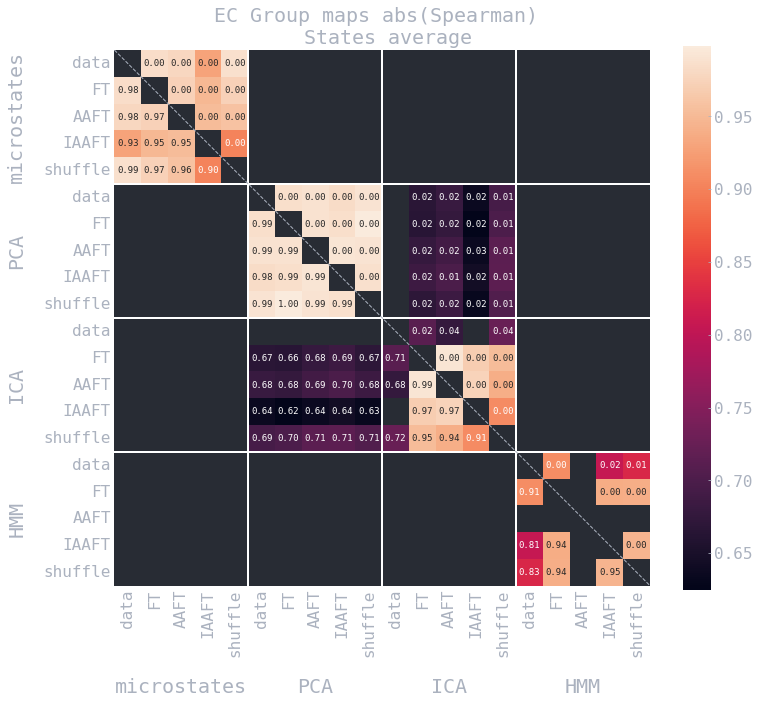

In [11]:
plot_matrix_w_annot(
    group_corrs.mean(axis=0),
    annot=True,
    mask_pvals=True,
    title="EC Group maps abs(Spearman) \n States average",
)

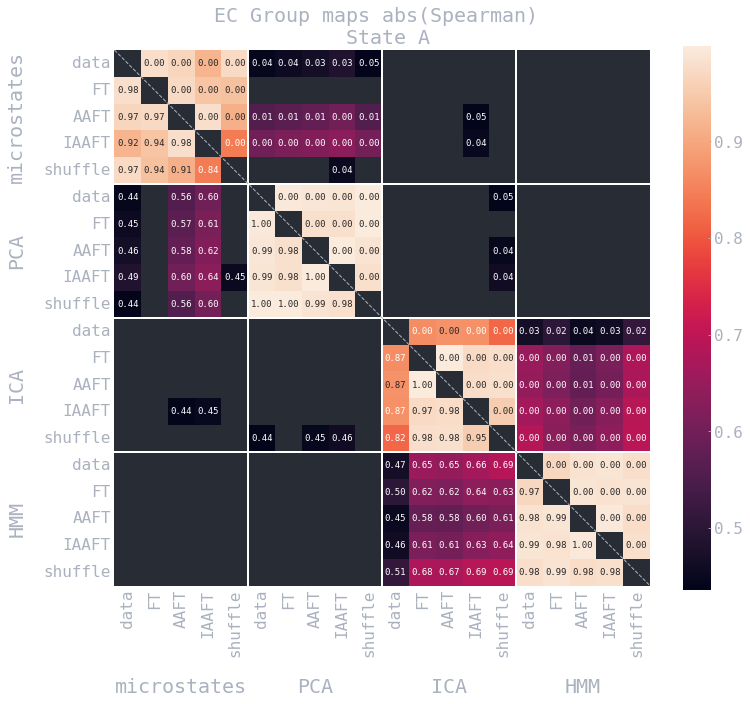

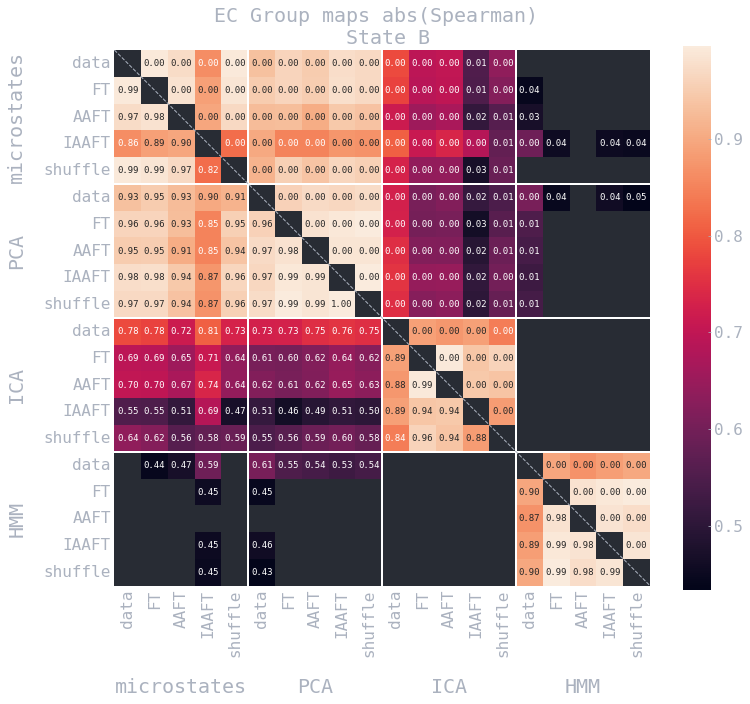

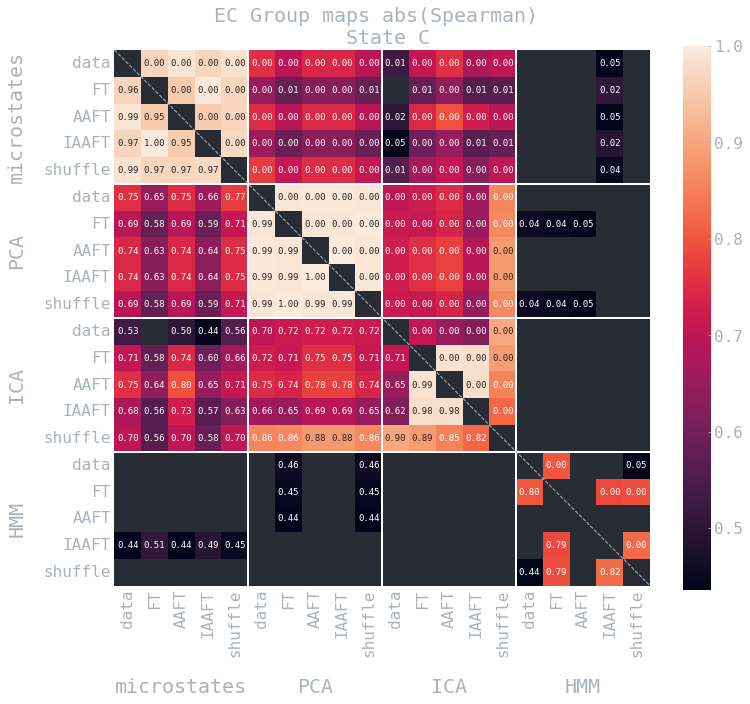

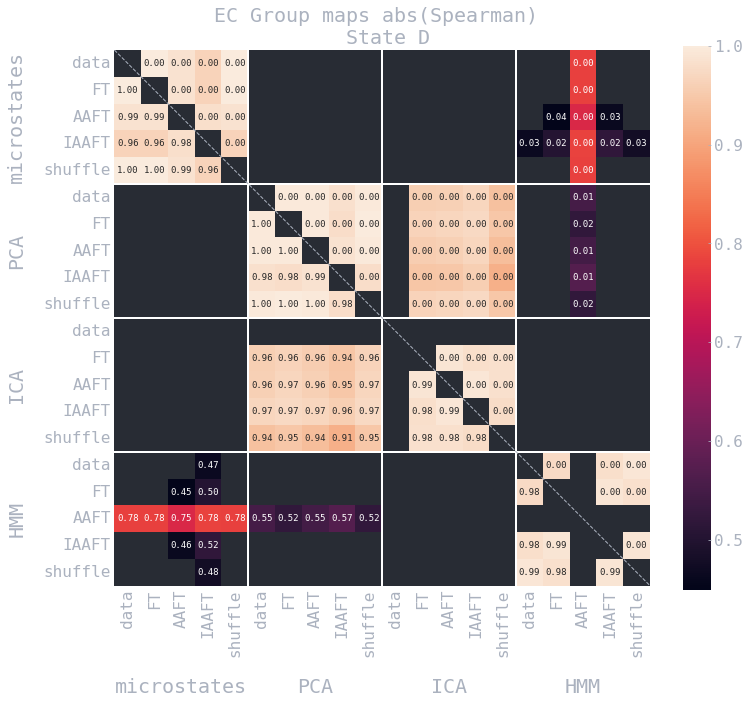

In [12]:
state_names = ["A", "B", "C", "D"]
for ms in range(4):
    plot_matrix_w_annot(
        group_corrs[ms, ...],
        annot=True,
        mask_pvals=True,
        title=f"EC Group maps abs(Spearman) \n State {state_names[ms]}",
    )

In [13]:
all_maps = []
for fold in ORDERED_FOLDERS:
    folder_maps = {}
    for file in sorted(glob(f"{os.path.join(RESULTS_ROOT, fold)}/sub*.npz")):
        subj = file.split("/")[-1].split("_")[0]
        if subj not in subjects_intersection:
            continue
        loaded = np.load(file)
        folder_maps[subj] = loaded["latent_maps"]
    all_maps.append(folder_maps)

In [14]:
map_corrs_subjectwise = np.zeros(
    (4, len(ORDERED_FOLDERS), len(ORDERED_FOLDERS), len(subjects_intersection), 2)
)
with tqdm(total=map_corrs_subjectwise.size // 2) as pbar:
    for i in range(len(ORDERED_FOLDERS)):
        for j in range(len(ORDERED_FOLDERS)):
            for k, sub in enumerate(subjects_intersection):
                for ms in range(4):
                    map_corrs_subjectwise[ms, i, j, k, :] = np.abs(
                        spearmanr(all_maps[i][sub][ms, :], all_maps[j][sub][ms, :])
                    )
                    pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323200/323200 [01:42<00:00, 3137.92it/s]


In [15]:
xr.DataArray(
    map_corrs_subjectwise,
    dims=["state", "decomp_type1", "decomp_type2", "subject", "value"],
    coords={
        "state": ["A", "B", "C", "D"],
        "decomp_type1": fold_names,
        "decomp_type2": fold_names,
        "subject": list(subjects_intersection),
        "value": ["measure", "p-value"],
    },
).to_netcdf(os.path.join(RESULTS_FOLDER, "subject_topomaps_EC_seeded.nc"))

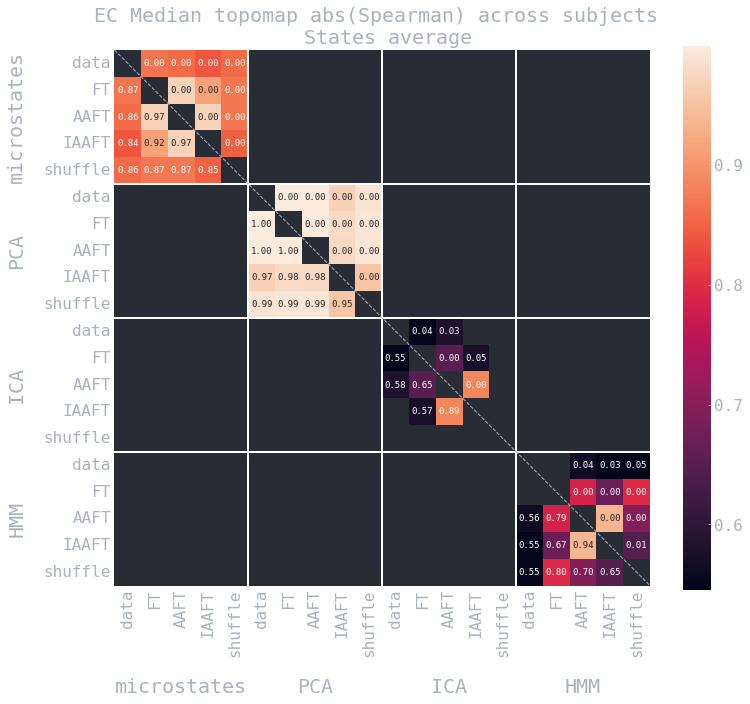

In [16]:
plot_matrix_w_annot(
    np.median(map_corrs_subjectwise.mean(axis=0), axis=-2),
    annot=True,
    mask_pvals=True,
    title="EC Median topomap abs(Spearman) across subjects \n States average",
)

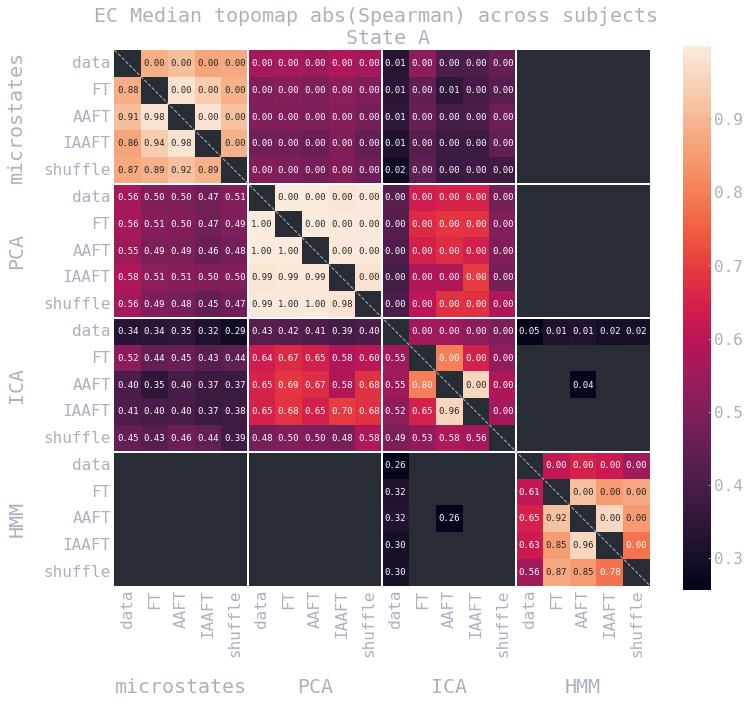

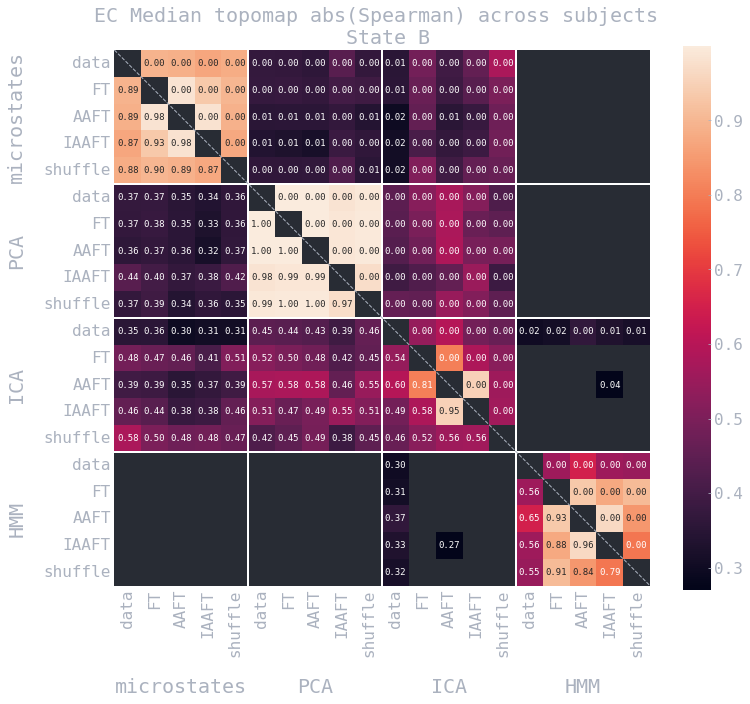

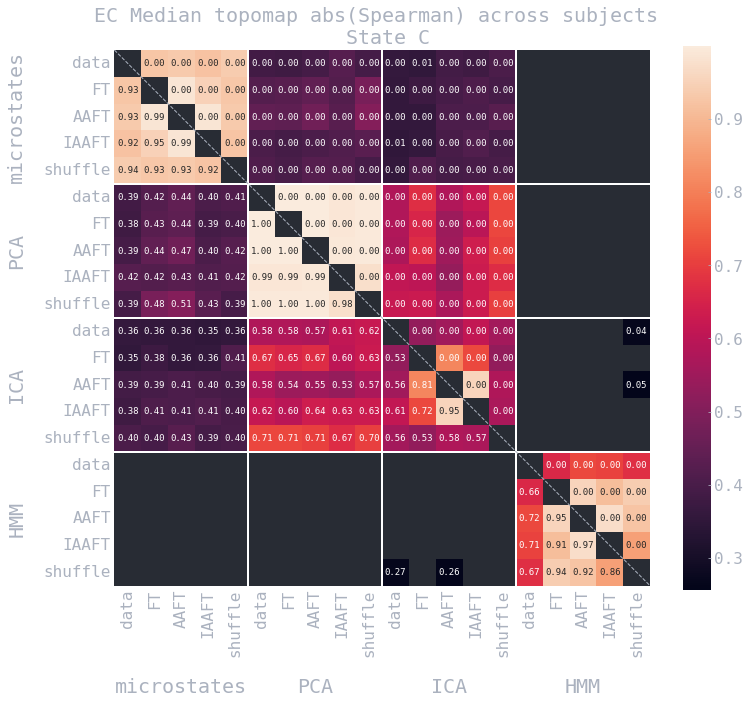

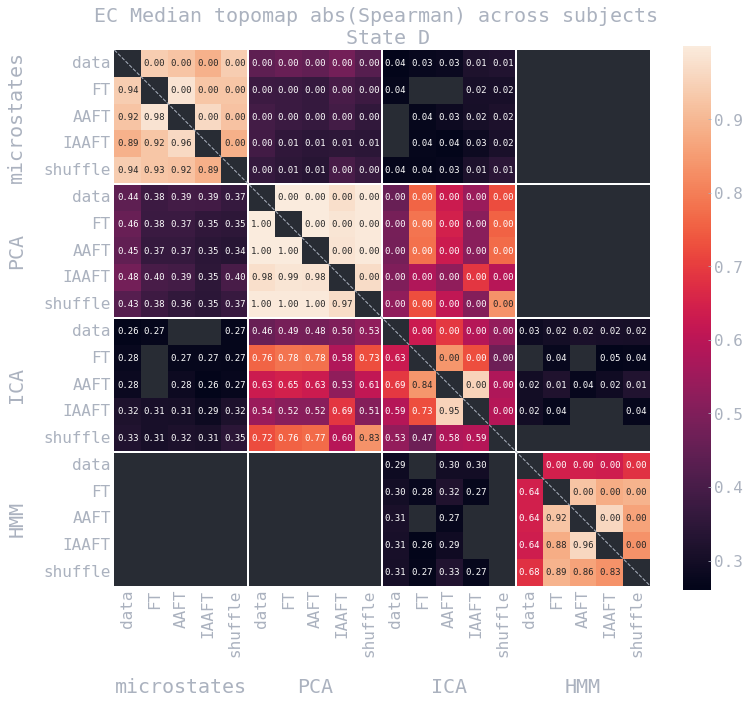

In [17]:
state_names = ["A", "B", "C", "D"]
for ms in range(4):
    plot_matrix_w_annot(
        np.median(map_corrs_subjectwise[ms, ...], axis=-2),
        annot=True,
        mask_pvals=True,
        title=f"EC Median topomap abs(Spearman) across subjects \n State {state_names[ms]}",
    )